In [51]:
from xbbg import blp
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import shap
import sklearn

import warnings
warnings.filterwarnings("ignore")

import pylab
import scipy.stats as stats

from dateutil.relativedelta import relativedelta

# Modifiable factor vectors
factors = ["USGG10Y INDEX", "CL1 COMDTY", "JB1 COMDTY", "SPX INDEX", "NKY INDEX"]
factors_jpy = ["USGG10Y INDEX", "SPX INDEX", "TTFG1MON SPEC INDEX", "FWISUS55 INDEX", "CTOTJPY INDEX"]
factors_chf = ["USGG10Y INDEX", "CL1 COMDTY", "GSWISS10 INDEX", "SX7E INDEX", "GDBR10 INDEX"]
factors_eur = ["USGG2Y INDEX", "GDBR10 INDEX", "CO1 COMDTY", "SX5E INDEX"]
factors_eur_tot = ["GBTPGR10 INDEX", "GDBR10 INDEX", "USGG10Y INDEX", "TZT2 COMDTY", "CTOTEUR INDEX"]
factors_aud = ["USGG10Y INDEX", "GACGB10 INDEX", "CL1 COMDTY", "IOE1 COMDTY", "SPX INDEX"]
factors_ARKK = ["USGG10Y INDEX", "GME US EQUITY", "XBT CURNCY"]
factors_equity = ["USGG2Y INDEX"]
factors_CNH = ["USGG10Y INDEX", "CL1 COMDTY", "UX1 INDEX", "SHSZ300 INDEX"]
factors_MXN = ["USGG10Y INDEX", "SPX INDEX", "CL1 COMDTY", "GMXN10Y INDEX"]
factors_ZAR = ["USGG10Y INDEX", "SPX INDEX", "CL1 COMDTY", "GSAB10Y INDEX"]
factors_NOK = ["USGG10Y INDEX", "SPX INDEX", "CL1 COMDTY", "GNOR10YR INDEX"]
factors_CAD = ["USGG10Y INDEX", "GCAN10Y INDEX", "CL1 COMDTY", "UX1 INDEX", "SPX INDEX", "HYG US EQUITY"]






In [52]:
def hist_data(tickers, start_date, end_date, condition = "PX_CLOSE_1D"):
    # Return a matrix of prices, with modifiable pricing condition
    data = blp.bdh(tickers, condition, start_date,end_date)
    data = data.dropna()
    return data



In [55]:
def regress_decomp(factors, response, lookback_days, interval_days, diff = True):
    tickers = factors[:]
    tickers.append(response)
    index = []
    rsq = []
    beta = []
    index = []
    
    # Call relevant data. Note we need data as far back as m+n (lookback + interval); to correct 
    # for numerical errors we call m+2*n samples
    bloomberg_data = hist_data(tickers = tickers, start_date = datetime.date.today() + relativedelta(days = -2*lookback_days-2*interval_days), 
                               end_date = datetime.date.today())
    scaler = sklearn.preprocessing.StandardScaler()
    
    # Iterative Regression
    for x in range(0, lookback_days):
        end_date = datetime.date.today() + relativedelta(days = -1*x)
        start_date = end_date + relativedelta(days = -1*interval_days)
        index.append(end_date)
        data = bloomberg_data[start_date:end_date]
        if diff:
            data = data.diff()
        data.dropna(inplace = True)
        col_rename = []
        for column in data.columns:
            col_rename.append(str(column[0]))
        data_scaled = pd.DataFrame(scaler.fit_transform(data), columns = data.columns, index = data.index)
        data_scaled.columns = col_rename
        dep_var = data_scaled[response]
        indep_var = data_scaled.drop(columns = response)
        total_model_prefit = sm.OLS(exog = indep_var, endog = dep_var)
        total_model = total_model_prefit.fit()
        
        # Compute multivariate R-squared, which we then subdivide individually
        total_rsq = total_model.rsquared
        rsq_row = []
        beta_row = []
        sum_rsq = 0
        if x == 0:
            print(total_model.summary())
            
        # Regress over each factor alone    
        for var in indep_var.columns:
            single_model = sm.OLS(exog = indep_var[var], endog = dep_var).fit()
            sum_rsq += single_model.rsquared
            rsq_row.append(single_model.rsquared)
            beta_row.append(single_model.params[0])
        
        # Rescale by total r-squared
        rsq_row_scaled = [i * total_rsq / sum_rsq for i in rsq_row]
        rsq.append(rsq_row_scaled)
        
        # For future use-saving down regression beta
        beta.append(beta_row)
        
        
    rsq_df = pd.DataFrame(rsq, columns = factors, index = index)
    plot = rsq_df.plot(stacked=True, kind="bar", figsize=(24,24), colormap = "Paired")
    plt.gca().invert_xaxis()
    plt.xticks(rotation = 45, fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xticks(np.arange(0, len(rsq)+1, 50))
    plt.title("%s Percent Explained Variance By Component, %i-CDay Sampling" % (response, interval_days), fontsize = 16)
    plt.xlabel("Date", fontsize = 14)
    plt.ylabel("Cumulative % Explain", fontsize = 14)
    plot.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1.0))
    return(rsq_df)


    
    

                                 OLS Regression Results                                
Dep. Variable:          USDJPY CURNCY   R-squared (uncentered):                   0.465
Model:                            OLS   Adj. R-squared (uncentered):              0.260
Method:                 Least Squares   F-statistic:                              2.264
Date:                Mon, 11 Jul 2022   Prob (F-statistic):                       0.109
Time:                        12:49:36   Log-Likelihood:                         -19.904
No. Observations:                  18   AIC:                                      49.81
Df Residuals:                      13   BIC:                                      54.26
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

,USGG10Y INDEX,SPX INDEX,TTFG1MON SPEC INDEX,FWISUS55 INDEX,CTOTJPY INDEX
2022-07-11,0.168425,0.022340,0.019032,0.174325,0.081338
2022-07-10,0.153788,0.019003,0.022546,0.165315,0.083532
2022-07-09,0.154348,0.017296,0.022645,0.165169,0.083952
2022-07-08,0.155867,0.008885,0.041746,0.153144,0.089432
2022-07-07,0.145929,0.013235,0.048799,0.148217,0.095500
...,...,...,...,...,...
2019-10-20,0.429015,0.234715,0.041813,0.103118,0.060305
2019-10-19,0.387961,0.205523,0.029743,0.125675,0.057458
2019-10-18,0.403389,0.216537,0.038668,0.079853,0.047120
2019-10-17,0.411025,0.227345,0.036357,0.086889,0.039759


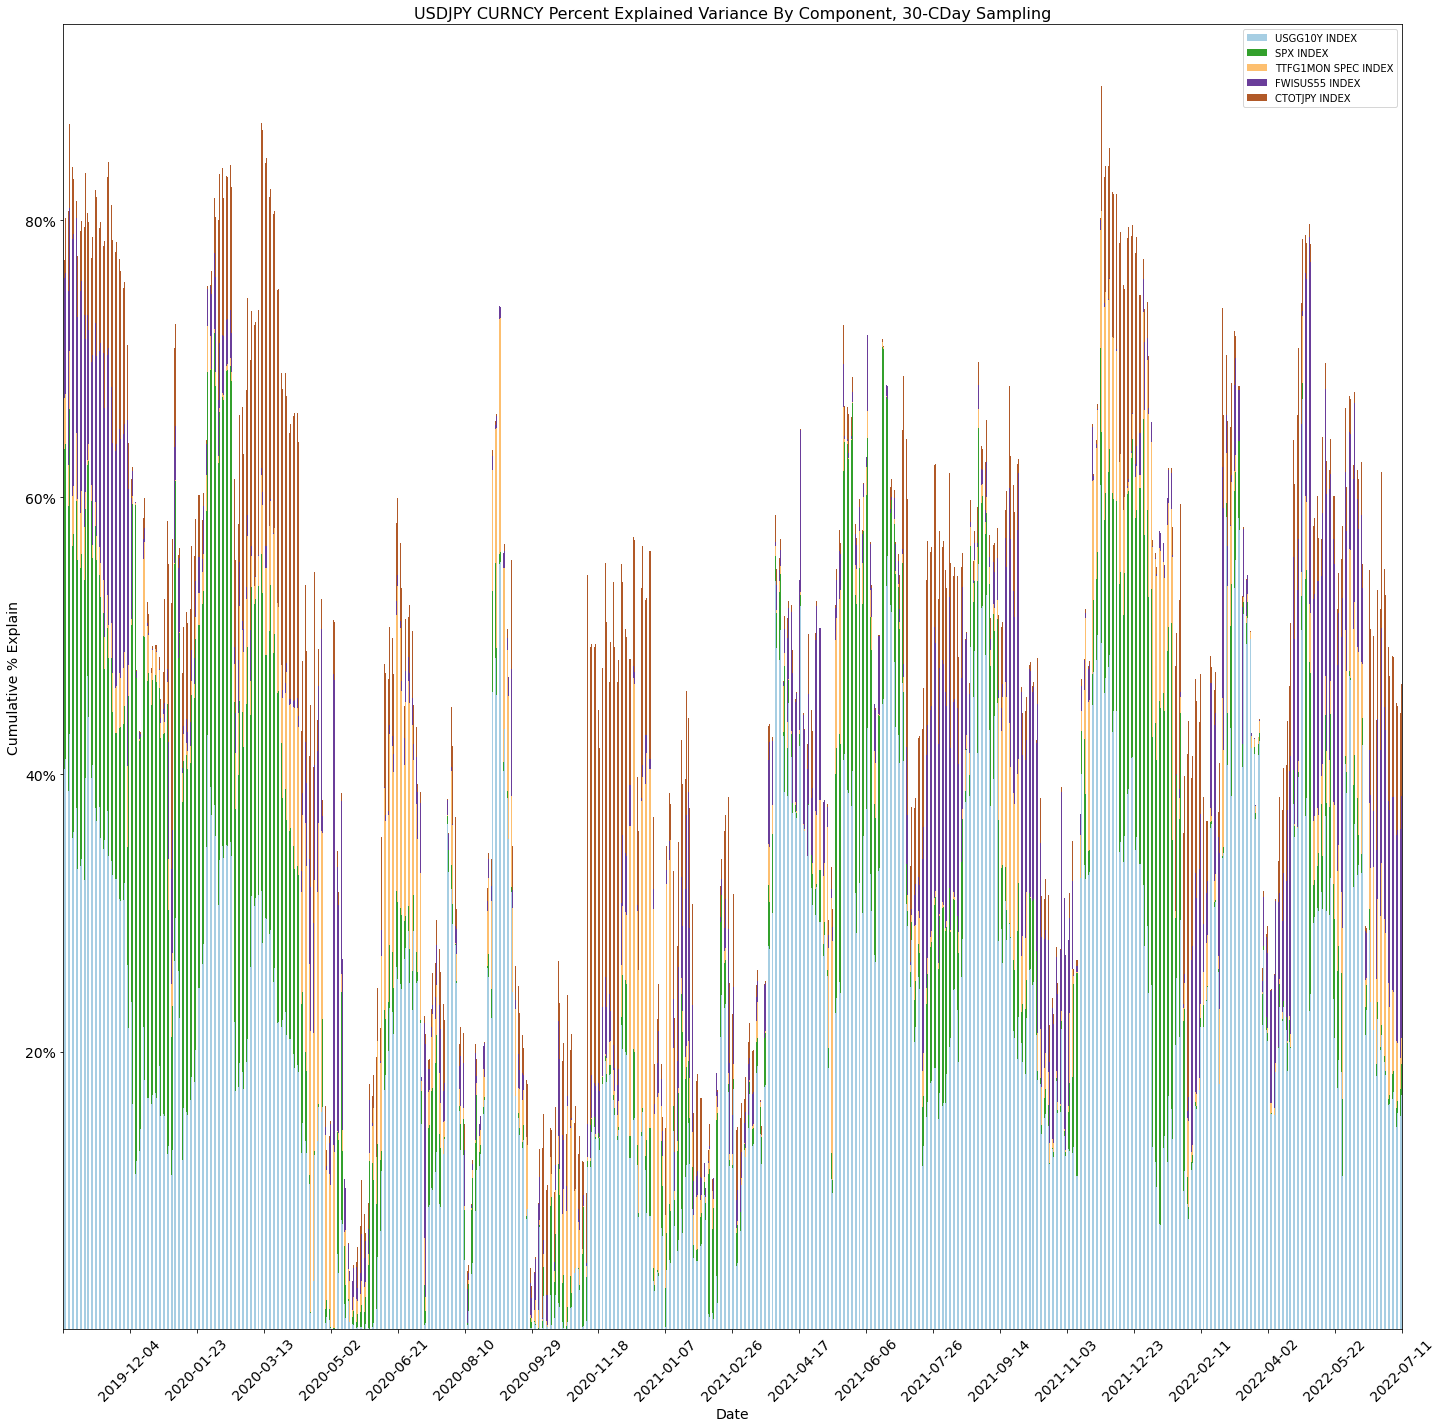

In [56]:
regress_decomp(factors_jpy, "USDJPY CURNCY", 1000, 30)

<class 'pandas.core.frame.DataFrame'>
Index: 2872 entries, 2010-11-19 to 2022-06-29
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   (USGG10Y INDEX, LAST_PRICE)   2872 non-null   float64
 1   (CL1 COMDTY, LAST_PRICE)      2872 non-null   float64
 2   (GSWISS10 INDEX, LAST_PRICE)  2872 non-null   float64
 3   (SX7E INDEX, LAST_PRICE)      2872 non-null   float64
 4   (GDBR10 INDEX, LAST_PRICE)    2872 non-null   float64
 5   (EURCHF CURNCY, LAST_PRICE)   2872 non-null   float64
dtypes: float64(6)
memory usage: 157.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 2022-03-02 to 2022-06-29
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LAST_PRICE  80 non-null     float64
dtypes: float64(1)
memory usage: 1.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 2022-03-02 to 2022-06-29
Data

,USGG10Y INDEX,CL1 COMDTY,GSWISS10 INDEX,SX7E INDEX,GDBR10 INDEX
2022-06-29,0.097736,0.025895,0.039619,0.129821,0.067520
2022-06-28,0.100231,0.029094,0.041763,0.131517,0.071084
2022-06-27,0.097440,0.027396,0.043095,0.130472,0.075792
2022-06-26,0.097238,0.027627,0.042984,0.130072,0.076150
2022-06-25,0.107743,0.032146,0.047157,0.147562,0.082146
...,...,...,...,...,...
2017-01-11,0.013767,0.004759,0.049531,0.029391,0.000053
2017-01-10,0.008832,0.009800,0.052478,0.041950,0.000135
2017-01-09,0.008952,0.010205,0.053532,0.042798,0.000140
2017-01-08,0.007494,0.007546,0.053872,0.041608,0.000332


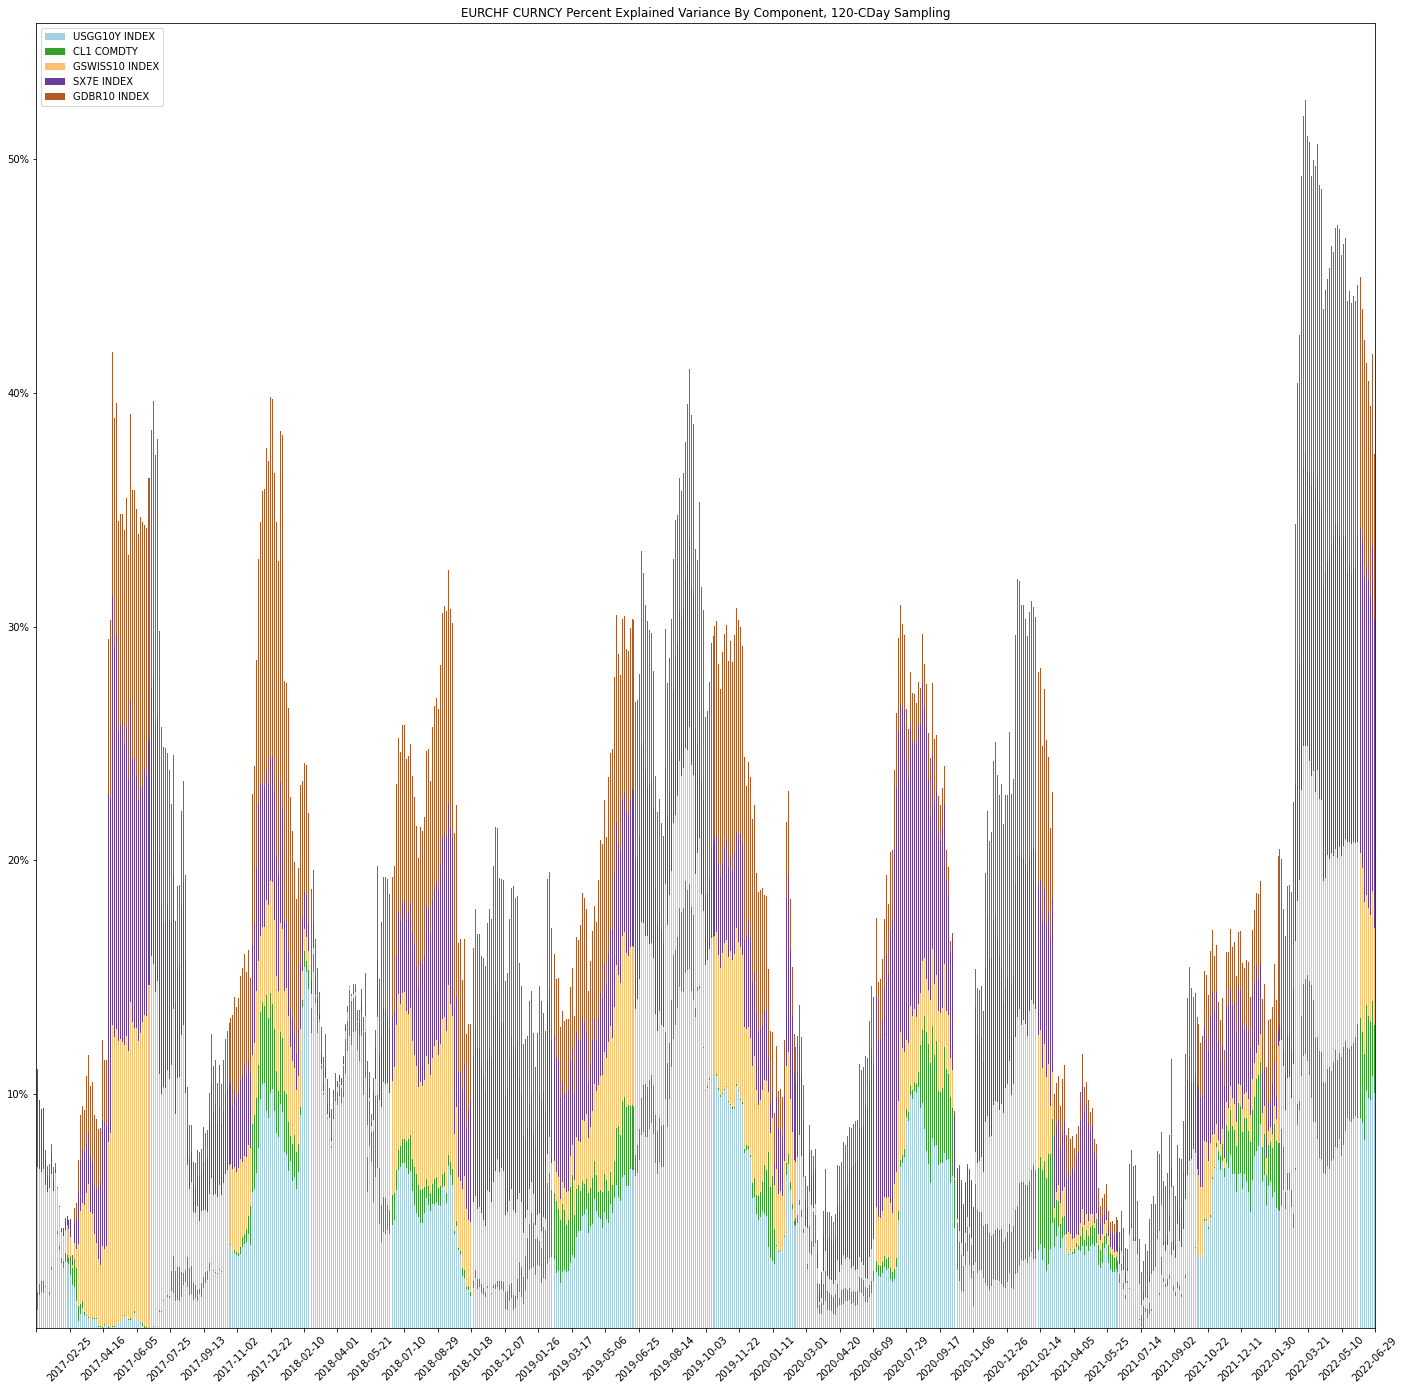

In [11]:
regress_decomp(factors_chf, "EURCHF CURNCY", 2000, 120)

                                 OLS Regression Results                                
Dep. Variable:     EURUSD L160 CURNCY   R-squared (uncentered):                   0.341
Model:                            OLS   Adj. R-squared (uncentered):              0.298
Method:                 Least Squares   F-statistic:                              7.864
Date:                Thu, 07 Jul 2022   Prob (F-statistic):                    5.21e-06
Time:                        15:53:00   Log-Likelihood:                          313.74
No. Observations:                  81   AIC:                                     -617.5
Df Residuals:                      76   BIC:                                     -605.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

,GBTPGR10 INDEX,GDBR10 INDEX,USGG10Y INDEX,TZT2 COMDTY,CTOTEUR INDEX
2022-07-07,0.001975,0.139788,0.007363,0.128970,0.062866
2022-07-06,0.001867,0.129579,0.003763,0.111999,0.056291
2022-07-05,0.012077,0.075979,0.018062,0.147467,0.055775
2022-07-04,0.012643,0.076594,0.023969,0.140689,0.056278
2022-07-03,0.012643,0.076594,0.023969,0.140689,0.056278
...,...,...,...,...,...
2017-01-19,0.046954,0.065010,0.129454,0.005970,0.001812
2017-01-18,0.047200,0.065983,0.139898,0.006534,0.001718
2017-01-17,0.048103,0.065351,0.127244,0.004635,0.001378
2017-01-16,0.047575,0.065248,0.125279,0.002126,0.001292


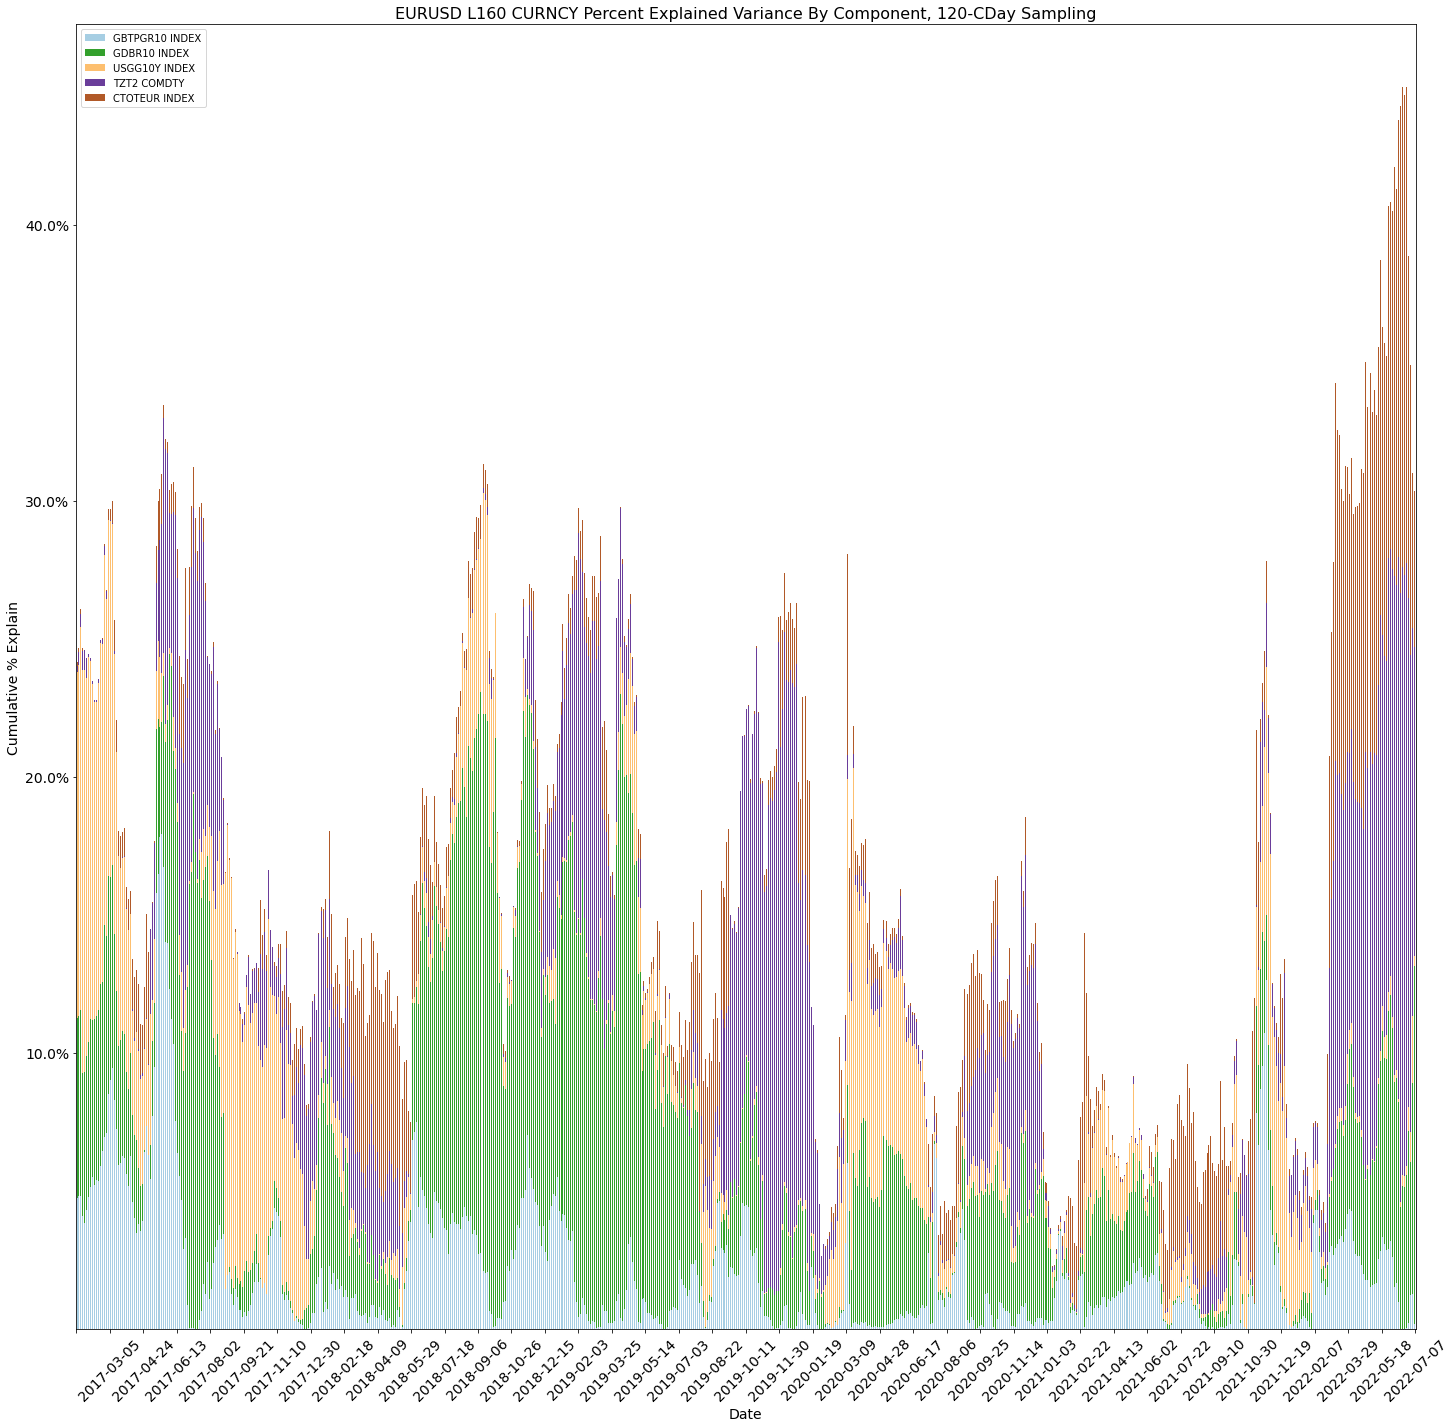

In [121]:
regress_decomp(factors_eur_tot, "EURUSD L160 CURNCY", 2000, 120)

<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 2013-10-21 to 2022-07-07
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   (USGG10Y INDEX, PX_CLOSE_1D)  1987 non-null   float64
 1   (GACGB10 INDEX, PX_CLOSE_1D)  1987 non-null   float64
 2   (CL1 COMDTY, PX_CLOSE_1D)     1987 non-null   float64
 3   (IOE1 COMDTY, PX_CLOSE_1D)    1987 non-null   float64
 4   (SPX INDEX, PX_CLOSE_1D)      1987 non-null   float64
 5   (AUDUSD CURNCY, PX_CLOSE_1D)  1987 non-null   float64
dtypes: float64(6)
memory usage: 108.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 2022-03-10 to 2022-07-07
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PX_CLOSE_1D  73 non-null     float64
dtypes: float64(1)
memory usage: 1.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 2022-03-10 to 2022-07-07
D

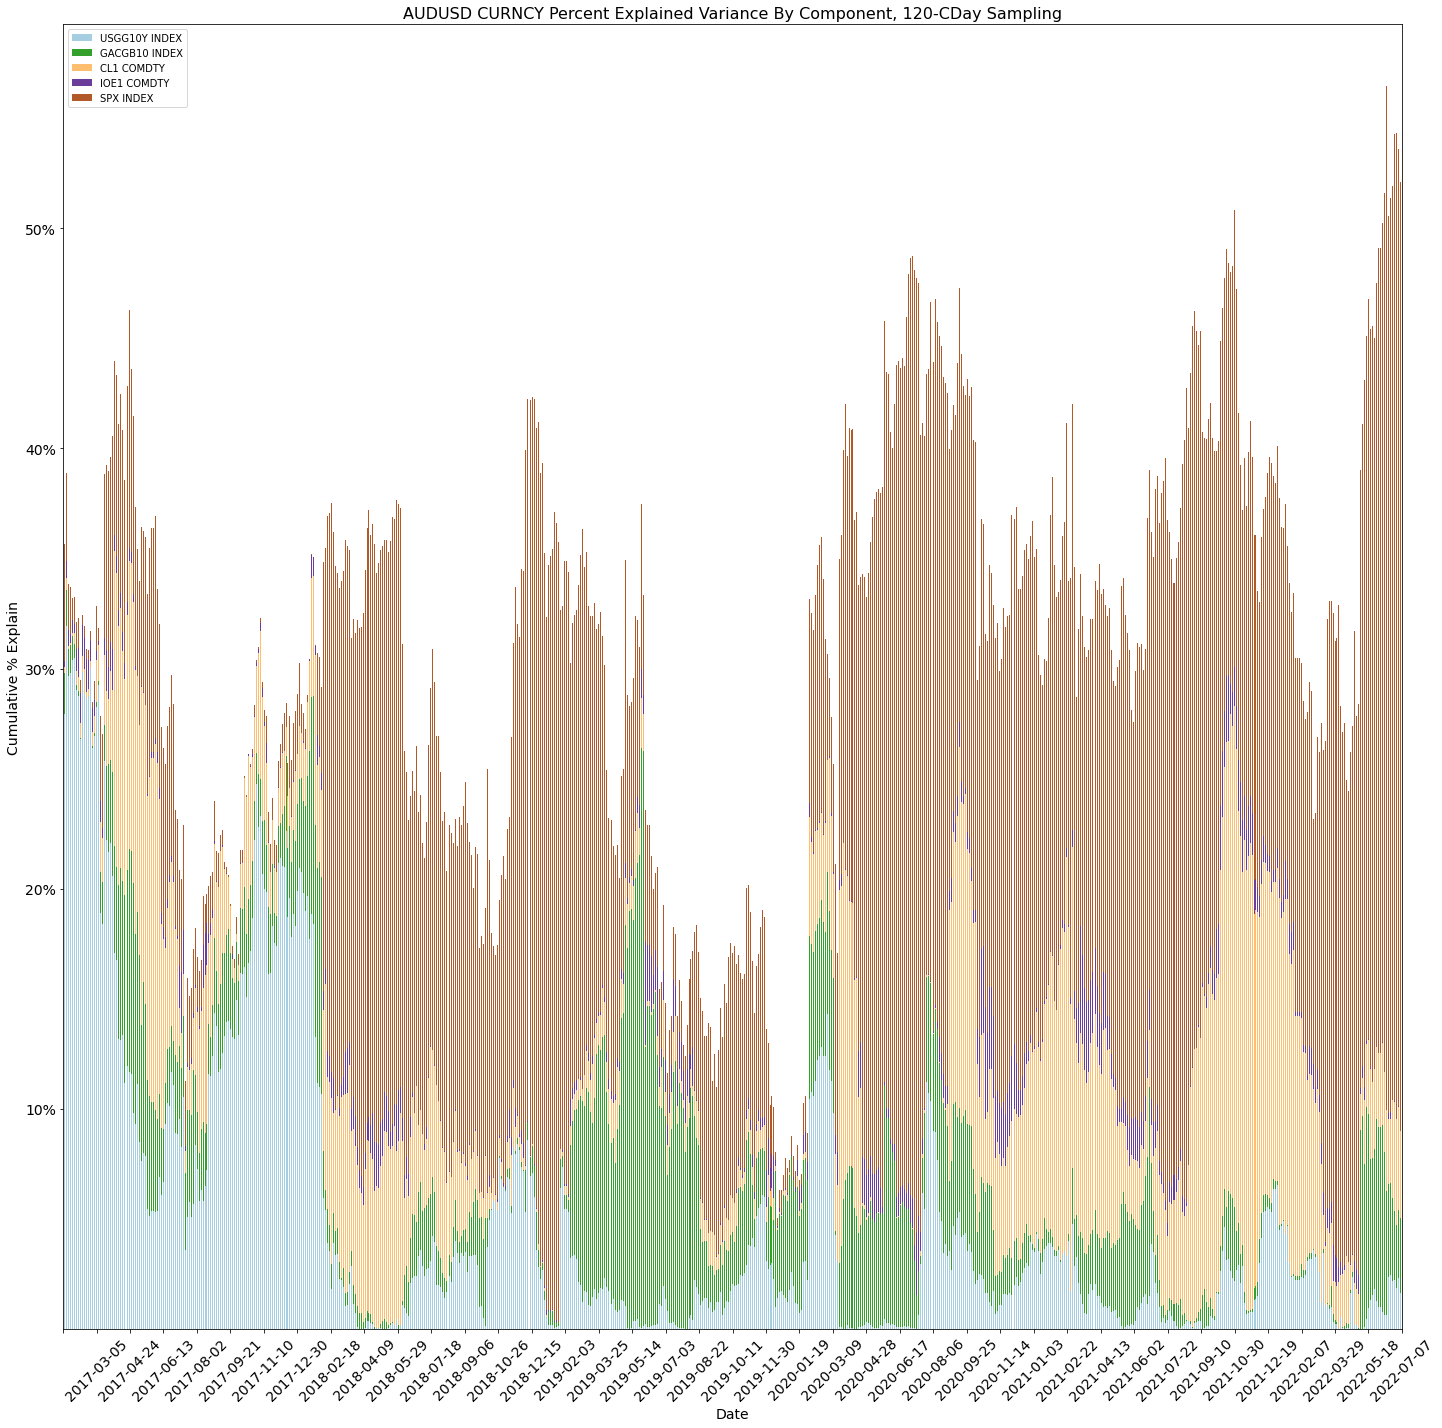

In [69]:
df_aud = regress_decomp(factors_aud, "AUDUSD CURNCY", 2000, 120)

<class 'pandas.core.frame.DataFrame'>
Index: 2729 entries, 2010-11-04 to 2022-06-14
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   (USGG10Y INDEX, LAST_PRICE)  2729 non-null   float64
 1   (CL1 COMDTY, LAST_PRICE)     2729 non-null   float64
 2   (UX1 INDEX, LAST_PRICE)      2729 non-null   float64
 3   (SHSZ300 INDEX, LAST_PRICE)  2729 non-null   float64
 4   (USDCNH CURNCY, LAST_PRICE)  2729 non-null   float64
dtypes: float64(5)
memory usage: 127.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 2022-02-15 to 2022-06-14
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LAST_PRICE  77 non-null     float64
dtypes: float64(1)
memory usage: 1.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 2022-02-15 to 2022-06-14
Data columns (total 4 columns):
 #   Column                       Non-

,USGG10Y INDEX,CL1 COMDTY,UX1 INDEX,SHSZ300 INDEX
2022-06-14,0.000185,0.000694,0.039662,0.070668
2022-06-13,0.000005,0.000392,0.038051,0.068943
2022-06-12,0.003893,0.000359,0.018236,0.065208
2022-06-11,0.004148,0.000276,0.017727,0.062819
2022-06-10,0.004156,0.000294,0.016899,0.062013
...,...,...,...,...
2016-12-27,0.252906,0.023252,0.001933,0.001127
2016-12-26,0.253673,0.023269,0.001916,0.001111
2016-12-25,0.253673,0.023269,0.001916,0.001111
2016-12-24,0.250652,0.023619,0.001778,0.001102


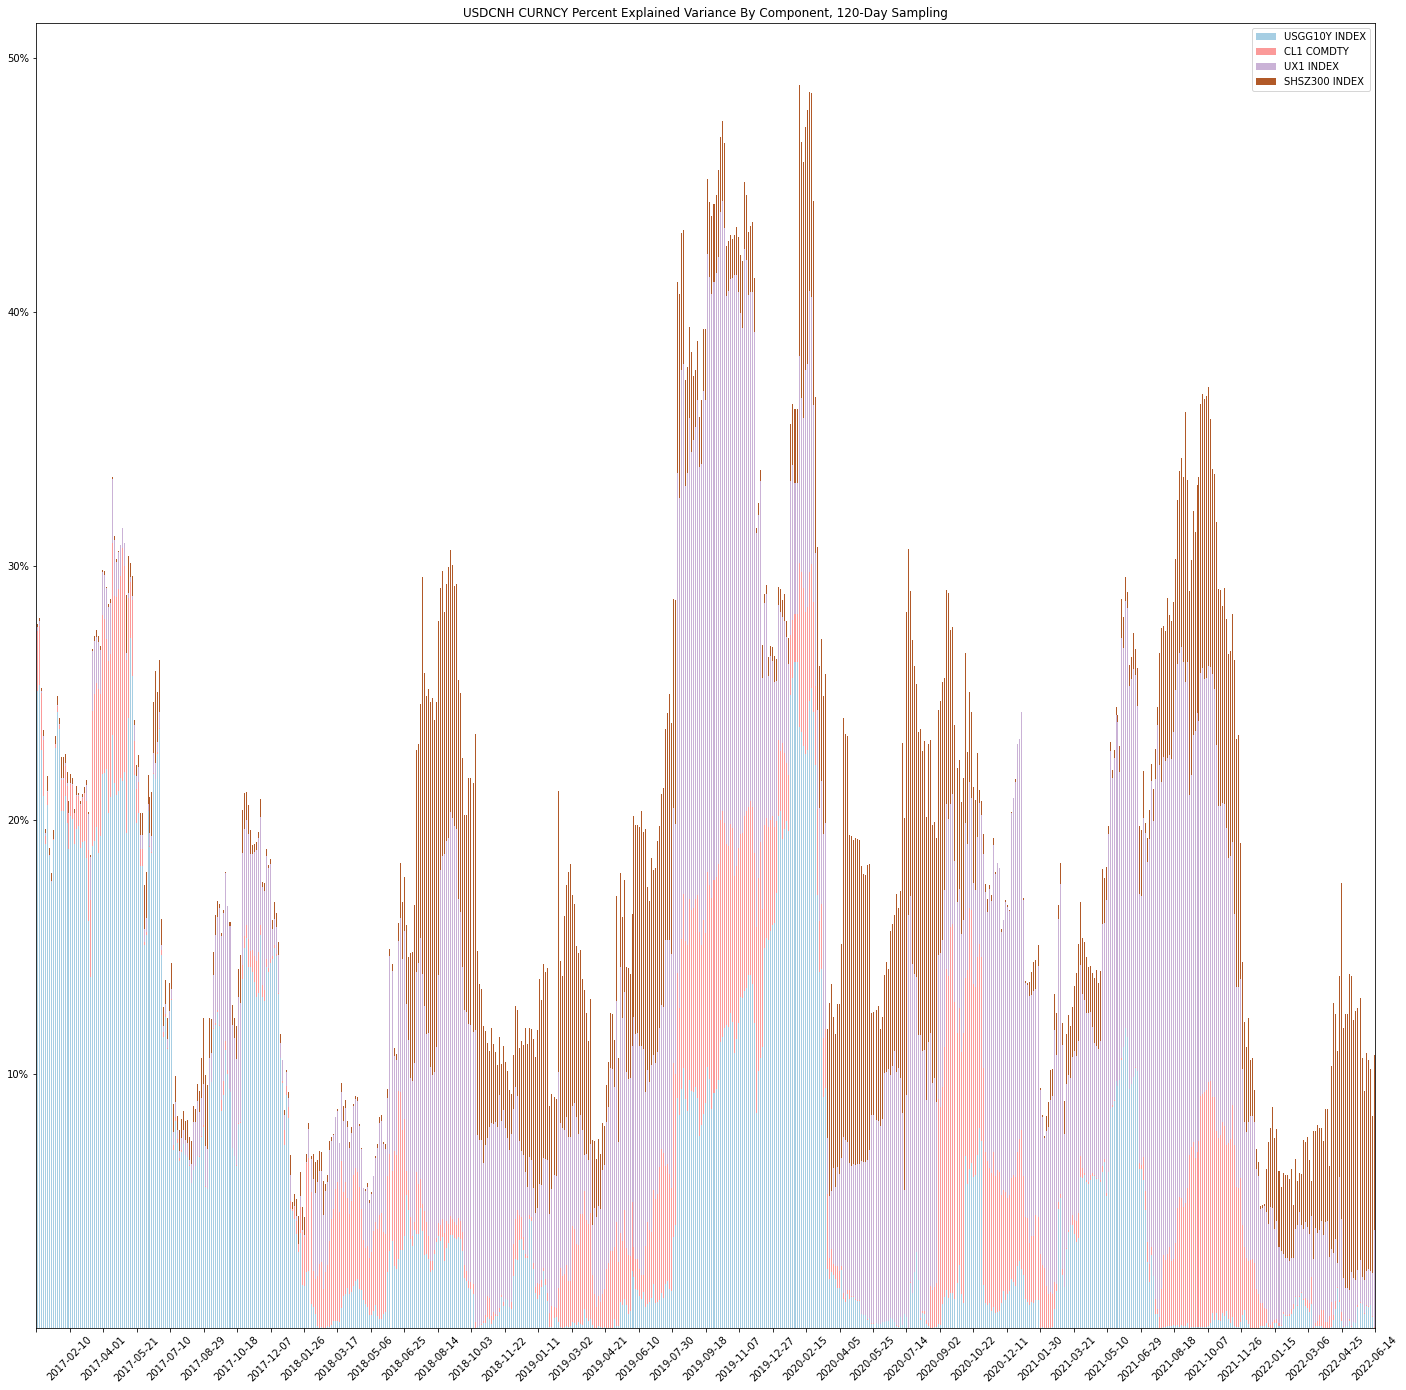

In [16]:
regress_decomp(factors_CNH, "USDCNH CURNCY", 2000, 120)

<class 'pandas.core.frame.DataFrame'>
Index: 2821 entries, 2010-11-29 to 2022-07-07
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   (USGG10Y INDEX, PX_CLOSE_1D)  2821 non-null   float64
 1   (SPX INDEX, PX_CLOSE_1D)      2821 non-null   float64
 2   (CL1 COMDTY, PX_CLOSE_1D)     2821 non-null   float64
 3   (GMXN10Y INDEX, PX_CLOSE_1D)  2821 non-null   float64
 4   (USDMXN CURNCY, PX_CLOSE_1D)  2821 non-null   float64
dtypes: float64(5)
memory usage: 132.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 2022-03-10 to 2022-07-07
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PX_CLOSE_1D  80 non-null     float64
dtypes: float64(1)
memory usage: 1.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 2022-03-10 to 2022-07-07
Data columns (total 4 columns):
 #   Column                 

,USGG10Y INDEX,SPX INDEX,CL1 COMDTY,GMXN10Y INDEX
2022-07-07,0.018308,0.294954,0.000605,0.108984
2022-07-06,0.016165,0.301857,0.000305,0.106927
2022-07-05,0.023367,0.316034,0.002341,0.146415
2022-07-04,0.030556,0.324693,0.001671,0.162060
2022-07-03,0.030556,0.324693,0.001671,0.162060
...,...,...,...,...
2017-01-19,0.175594,0.006997,0.032927,0.444407
2017-01-18,0.160683,0.008419,0.027339,0.457597
2017-01-17,0.156555,0.009539,0.027076,0.463375
2017-01-16,0.158436,0.009426,0.027495,0.464456


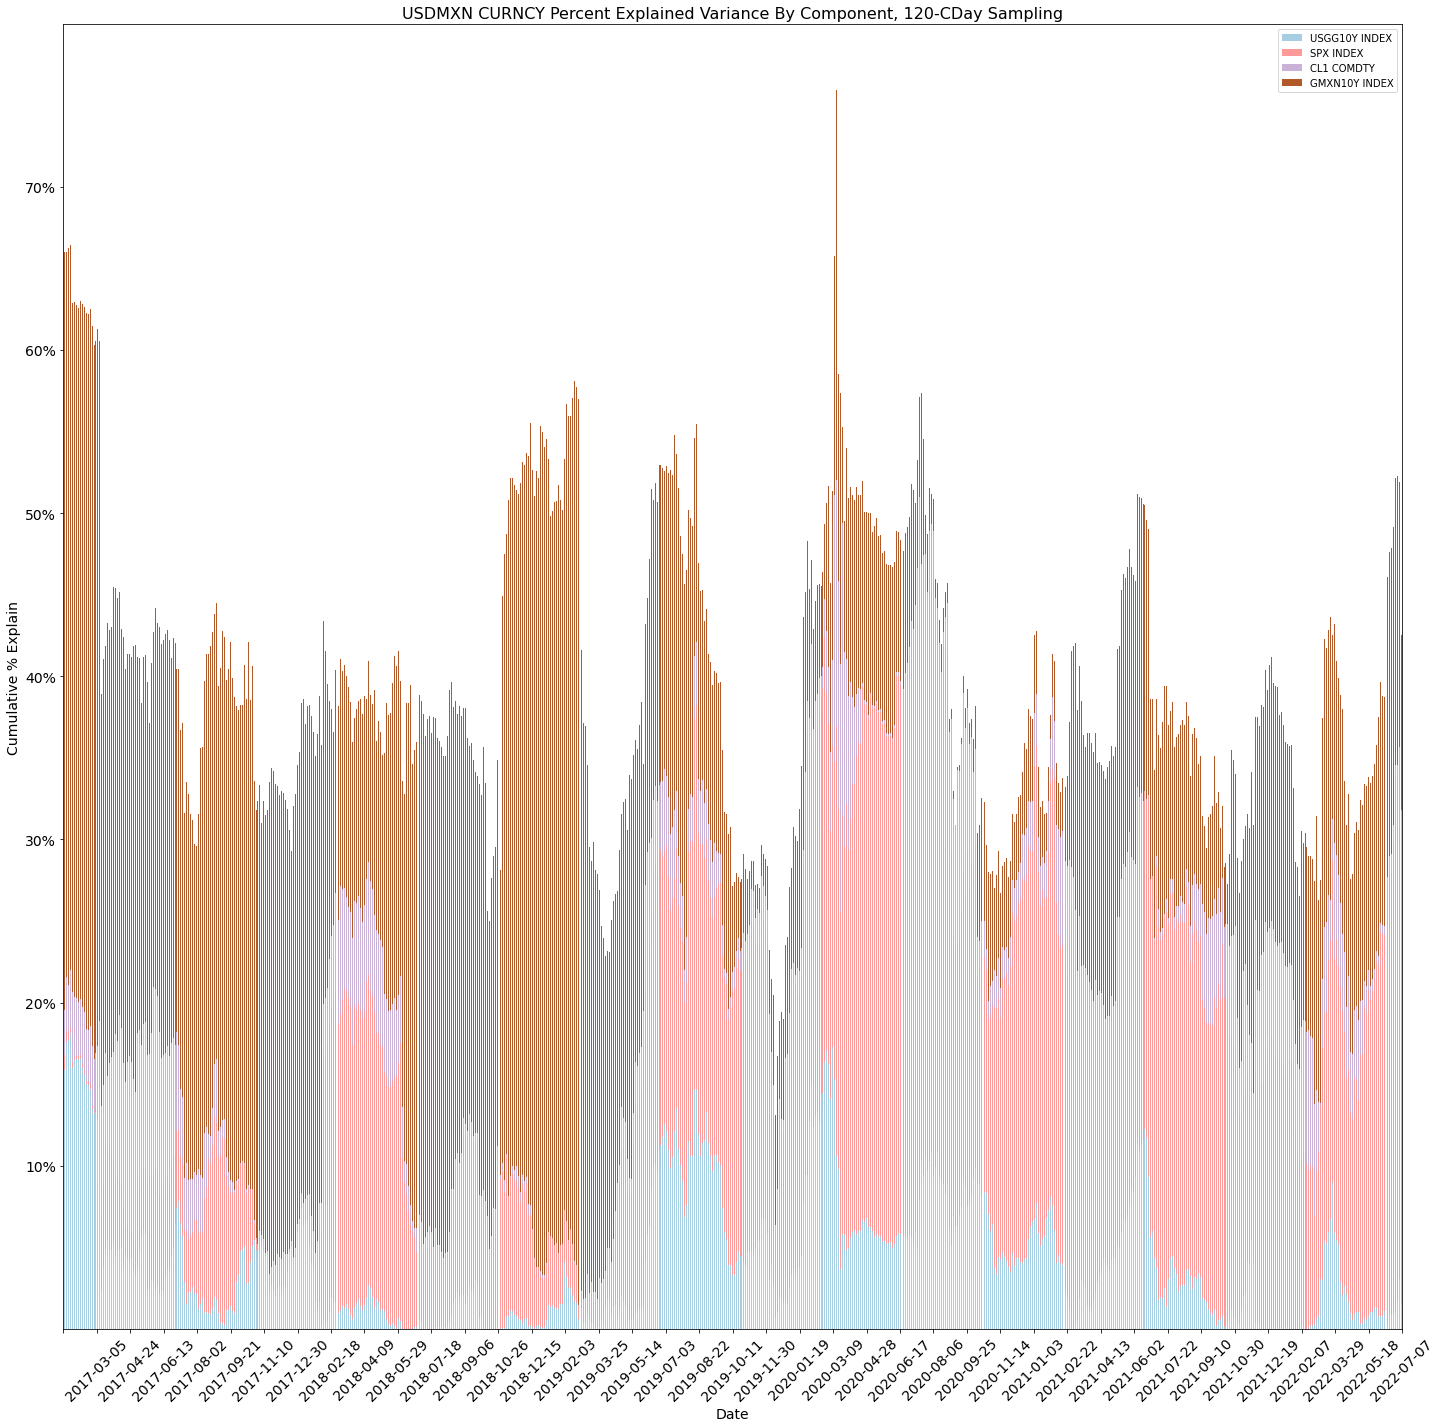

In [67]:
regress_decomp(factors_MXN, "USDMXN CURNCY", 2000, 120)

<class 'pandas.core.frame.DataFrame'>
Index: 1244 entries, 2016-04-20 to 2022-06-07
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   (USGG10Y INDEX, LAST_PRICE)  1244 non-null   float64
 1   (SPX INDEX, LAST_PRICE)      1244 non-null   float64
 2   (CL1 COMDTY, LAST_PRICE)     1244 non-null   float64
 3   (GSAB10Y INDEX, LAST_PRICE)  1244 non-null   float64
 4   (USDZAR CURNCY, LAST_PRICE)  1244 non-null   float64
dtypes: float64(5)
memory usage: 58.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 2022-02-09 to 2022-06-07
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LAST_PRICE  78 non-null     float64
dtypes: float64(1)
memory usage: 1.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 2022-02-09 to 2022-06-07
Data columns (total 4 columns):
 #   Column                       Non-N

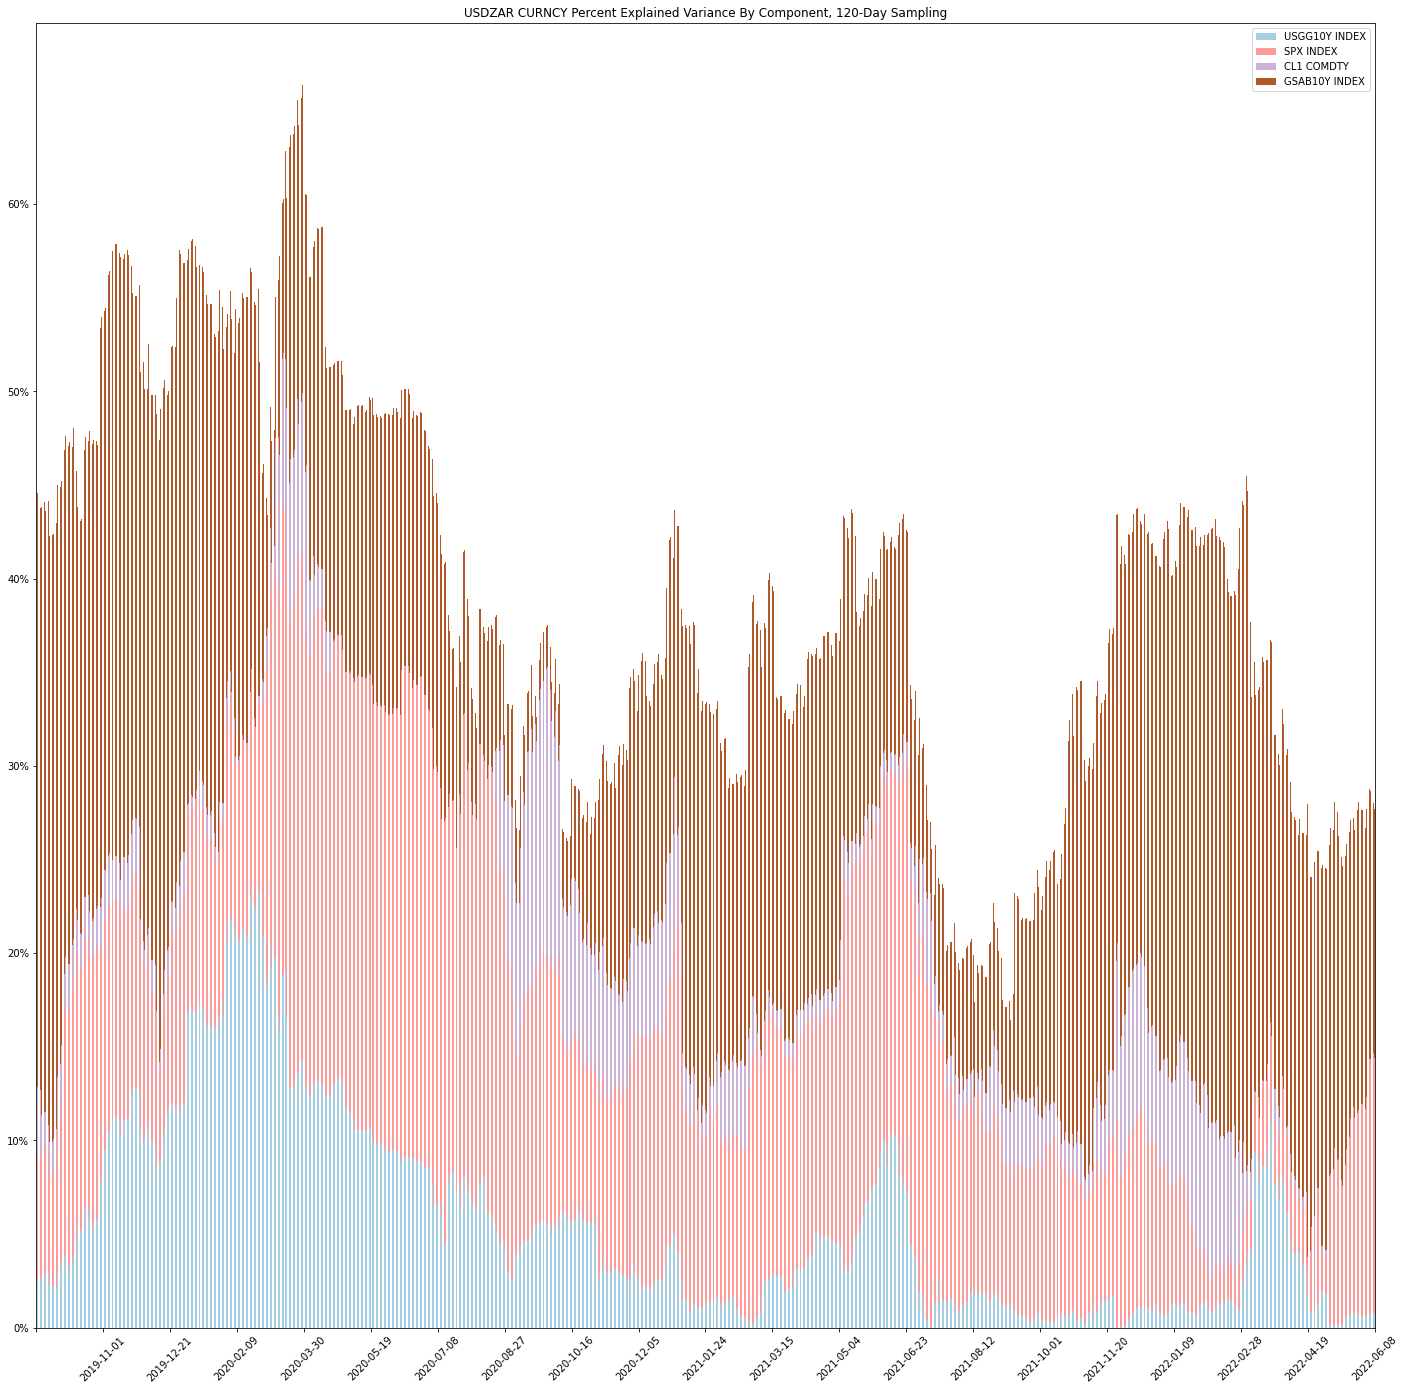

In [330]:
regress_decomp(factors_ZAR, "USDZAR CURNCY", 1000, 120)

<class 'pandas.core.frame.DataFrame'>
Index: 2847 entries, 2010-11-29 to 2022-07-07
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   (USGG10Y INDEX, PX_CLOSE_1D)  2847 non-null   float64
 1   (GCAN10Y INDEX, PX_CLOSE_1D)  2847 non-null   float64
 2   (CL1 COMDTY, PX_CLOSE_1D)     2847 non-null   float64
 3   (UX1 INDEX, PX_CLOSE_1D)      2847 non-null   float64
 4   (SPX INDEX, PX_CLOSE_1D)      2847 non-null   float64
 5   (HYG US EQUITY, PX_CLOSE_1D)  2847 non-null   float64
 6   (USDCAD CURNCY, PX_CLOSE_1D)  2847 non-null   float64
dtypes: float64(7)
memory usage: 177.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 2022-03-10 to 2022-07-07
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PX_CLOSE_1D  80 non-null     float64
dtypes: float64(1)
memory usage: 1.2+ KB
<class 'pandas.core.fram

,USGG10Y INDEX,GCAN10Y INDEX,CL1 COMDTY,UX1 INDEX,SPX INDEX,HYG US EQUITY
2022-07-07,0.002847,0.000052,0.042769,0.201042,0.242174,0.140798
2022-07-06,0.003515,0.000004,0.037369,0.192679,0.240816,0.140351
2022-07-05,0.007906,0.001680,0.018113,0.210917,0.263374,0.151254
2022-07-04,0.006577,0.001153,0.018658,0.210823,0.264325,0.150792
2022-07-03,0.006577,0.001153,0.018658,0.210823,0.264325,0.150792
...,...,...,...,...,...,...
2017-01-19,0.188013,0.012050,0.179214,0.035430,0.048662,0.136842
2017-01-18,0.140761,0.005672,0.155333,0.045984,0.059904,0.155043
2017-01-17,0.117560,0.003473,0.154044,0.046313,0.067297,0.159843
2017-01-16,0.115787,0.003023,0.152421,0.047502,0.068538,0.160441


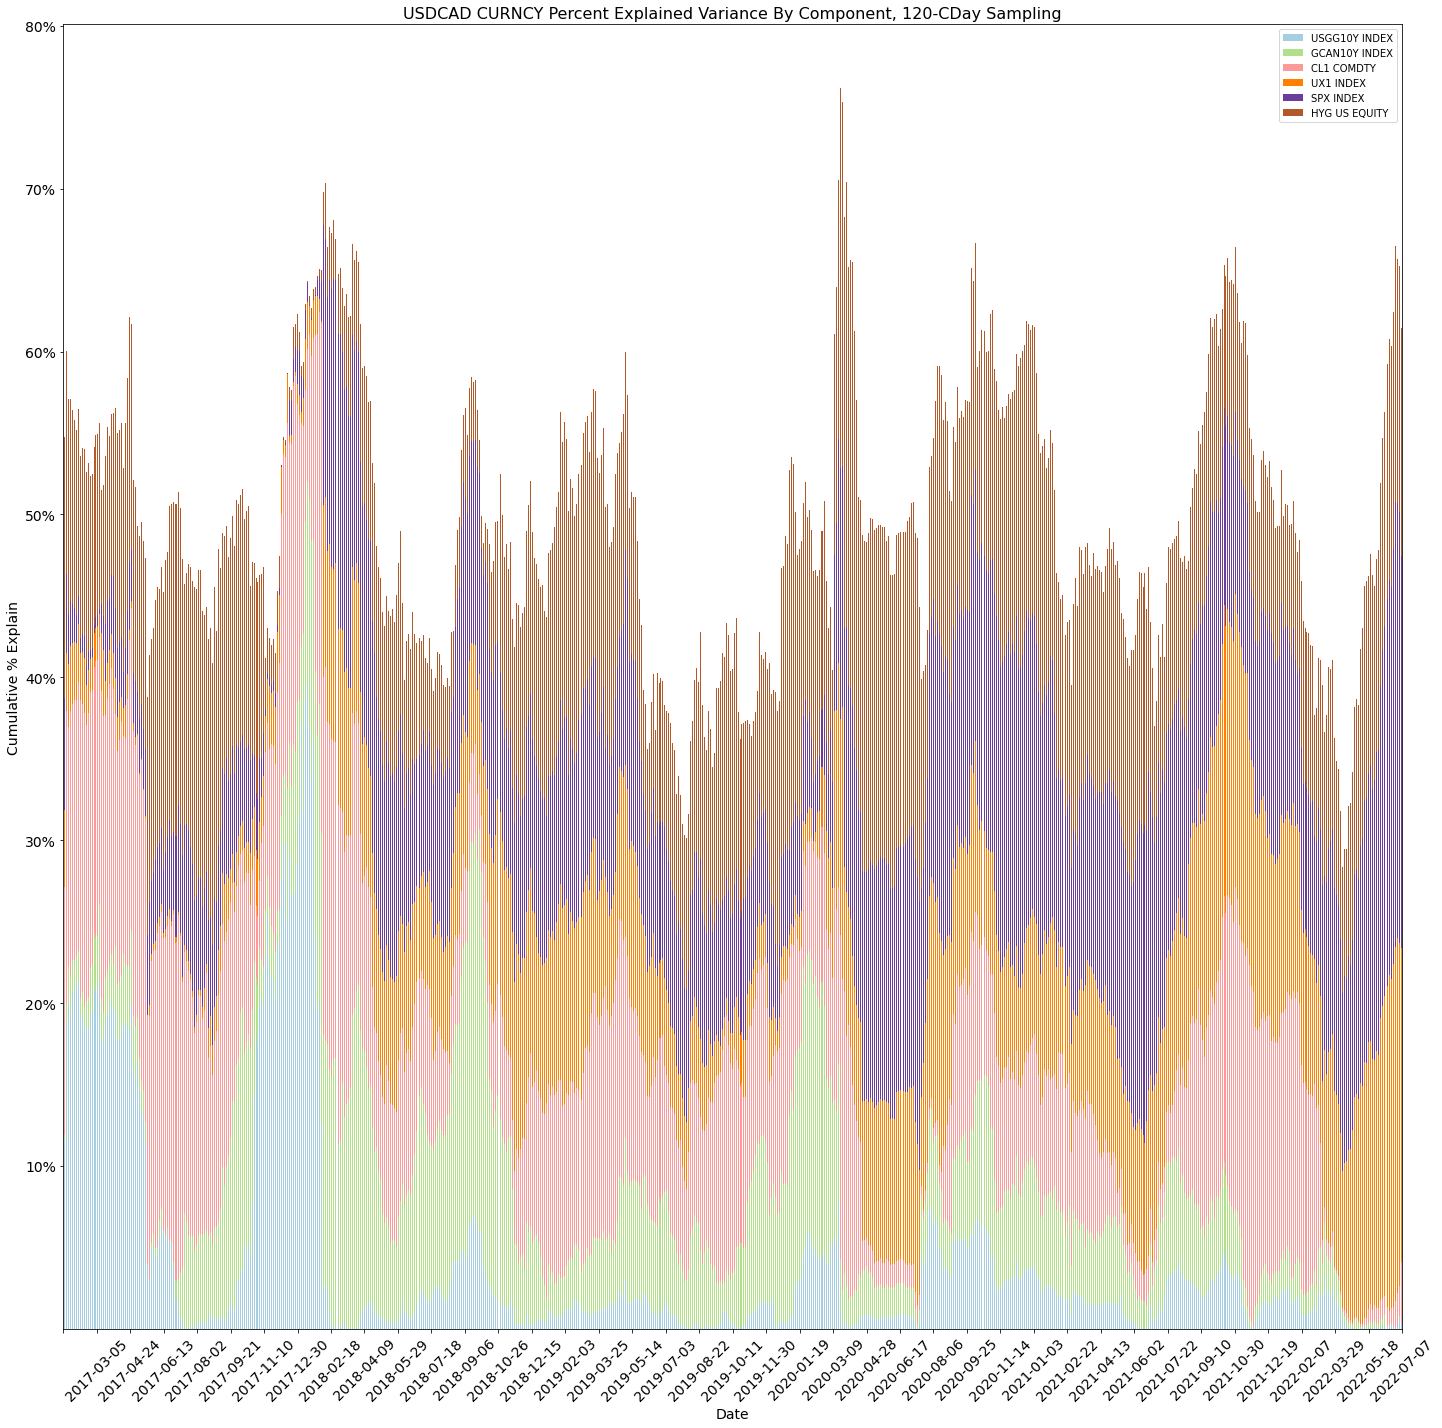

In [68]:
regress_decomp(factors_CAD, "USDCAD CURNCY", 2000, 120)